# G crypto competition

This notebook is prep for the G-Research Crypto Forecasting Kaggle Competition. The data has explored, prepped, and run through TimeInception Model

### I'm not a timeseries expert, I wrote this in order to learn Tsai (fastai's timeseries module)

In [1]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import DateOffset
import datetime as dt
import os

In [2]:
# get the asset details into dictionaries

file = 'asset_details.csv'

assetDetails = (pd.read_csv(file)).sort_values(by = ['Asset_ID']).reset_index(drop = True)

names = {}
weights = {}

for row in assetDetails.index:
    assetID = assetDetails.at[row, 'Asset_ID'] 
    names[assetID] = assetDetails.at[row, 'Asset_Name']
    weights[assetID] = assetDetails.at[row, 'Weight']

print(names)
print(weights)

{0: 'Binance Coin', 1: 'Bitcoin', 2: 'Bitcoin Cash', 3: 'Cardano', 4: 'Dogecoin', 5: 'EOS.IO', 6: 'Ethereum', 7: 'Ethereum Classic', 8: 'IOTA', 9: 'Litecoin', 10: 'Maker', 11: 'Monero', 12: 'Stellar', 13: 'TRON'}
{0: 4.30406509320417, 1: 6.779921907472252, 2: 2.3978952727983707, 3: 4.406719247264253, 4: 3.555348061489413, 5: 1.3862943611198906, 6: 5.8944028342648505, 7: 2.079441541679836, 8: 1.0986122886681098, 9: 2.3978952727983707, 10: 1.0986122886681098, 11: 1.6094379124341005, 12: 2.079441541679836, 13: 1.791759469228055}


Load Data

- Get training data
- Get supplemental data
- Combine

In [3]:
data = pd.read_csv("train.csv")

In [4]:
data['timestamp'] = pd.to_datetime(data['timestamp'], unit = 's')

In [5]:
data.set_index(['timestamp'], inplace = True)

In [6]:
#my machine is not that powerful so I decided to only work on 1 month worth of data and one asset
data = data[data.index.get_level_values('timestamp') > '2021-08-10'] 

In [7]:
data = data[data.Asset_ID==2]

In [8]:
data.head(2)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,Target
timestamp,,,,,,,,,
2021-08-10 00:01:00,2,264.0,590.376000,591.46,590.13,590.602000,221.703763,590.767161,-0.003221
2021-08-10 00:02:00,2,451.0,590.846667,593.68,590.38,593.191667,319.139465,592.418999,-0.002114


Prep Data and Explore

- Add in feature columns to create a 'final' dataframe
- Review data types, correlations, and the target's distribution

In [9]:
# create functions to add in feature cols
def FeatureCols(df):
    data['hlDiff'] = data['High'] - data['Low'] # high - low to measure volitility
    
    # shadows
    data['uShadow'] = data['High'] - np.maximum(data['Close'], data['Open'])
    data['bShadow'] = np.minimum(data['Close'], data['Open']) - data['Low']
    
    # encode minute from timestamp
    data['minute'] = data.index.get_level_values('timestamp').minute
    data['minSin'] = np.sin(data.minute*(2.*np.pi/60))
    data["minCos"] = np.cos(data.minute*(2.*np.pi/60))
    
    data.drop(columns = ['minute'], axis = 1, inplace = True) # clear progress columns
    
    return (data)

In [11]:
final = FeatureCols(data) # Apply feature cols to the entire dataset
final = final[ [ col for col in final.columns if col != 'Target' ] + ['Target'] ] # move target to end
final.head(20)

,Asset_ID,Count,Open,High,Low,Close,Volume,VWAP,hlDiff,uShadow,bShadow,minSin,minCos,Target
timestamp,,,,,,,,,,,,,,
2021-08-10 00:01:00,2,264.0,590.376000,591.46,590.13,590.602000,221.703763,590.767161,1.33,0.858000,0.246000,0.104528,9.945219e-01,-0.003221
2021-08-10 00:02:00,2,451.0,590.846667,593.68,590.38,593.191667,319.139465,592.418999,3.30,0.488333,0.466667,0.207912,9.781476e-01,-0.002114
2021-08-10 00:03:00,2,378.0,593.500000,594.85,593.12,593.793333,338.559902,594.019835,1.73,1.056667,0.380000,0.309017,9.510565e-01,-0.001416
2021-08-10 00:04:00,2,296.0,593.326000,593.84,591.85,592.870000,320.023899,592.754957,1.99,0.514000,1.020000,0.406737,9.135455e-01,-0.000574
2021-08-10 00:05:00,2,821.0,593.258333,595.55,592.55,594.738333,643.039069,594.319980,3.00,0.811667,0.708333,0.500000,8.660254e-01,0.000865
2021-08-10 00:06:00,2,889.0,595.062000,596.29,594.58,595.096000,715.731165,595.441865,1.71,1.194000,0.482000,0.587785,8.090170e-01,0.000617
2021-08-10 00:07:00,2,247.0,595.396000,596.15,595.19,595.690000,241.641460,595.668901,0.96,0.460000,0.206000,0.669131,7.431448e-01,0.000363
2021-08-10 00:08:00,2,352.0,595.308333,595.69,594.00,594.751667,378.457639,594.945327,1.69,0.381667,0.751667,0.743145,6.691306e-01,0.001347
2021-08-10 00:09:00,2,565.0,594.553333,599.15,591.74,592.206667,1210.529510,593.589712,7.41,4.596667,0.466667,0.809017,5.877853e-01,0.000531


## Building the model

In [12]:
from tsai.all import *

In [13]:
final = final.drop(["Asset_ID","Count","Open","High","Low"], axis=1)

In [14]:
final.head()

,Close,Volume,VWAP,hlDiff,uShadow,bShadow,minSin,minCos,Target
timestamp,,,,,,,,,
2021-08-10 00:01:00,590.602000,221.703763,590.767161,1.33,0.858000,0.246000,0.104528,0.994522,-0.003221
2021-08-10 00:02:00,593.191667,319.139465,592.418999,3.30,0.488333,0.466667,0.207912,0.978148,-0.002114
2021-08-10 00:03:00,593.793333,338.559902,594.019835,1.73,1.056667,0.380000,0.309017,0.951057,-0.001416
2021-08-10 00:04:00,592.870000,320.023899,592.754957,1.99,0.514000,1.020000,0.406737,0.913545,-0.000574
2021-08-10 00:05:00,594.738333,643.039069,594.319980,3.00,0.811667,0.708333,0.500000,0.866025,0.000865


In [15]:
window_length = 60  # window_length is usually selected based on prior domain knowledge or by trial and error
stride = None                # None for non-overlapping (stride = window_length) (default = 1). This depends on how often you want to predict once the model is trained
start = 0                    # use all data since the first time stamp (default = 0)
get_x = final.columns[:-1]      # Indicates which are the columns that contain the x data.
get_y = 'Target'             # In multivariate time series, you must indicate which is/are the y columns
horizon = 0                  # 0 means y is taken from the last time stamp of the time sequence (default = 0)
seq_first = True
                            
X, y = SlidingWindow(window_length, stride=stride, start=start, get_x=get_x,  get_y=get_y, horizon=horizon, seq_first=seq_first)(final)

In English, we are using 60 points worth of data in order to predict the target of the 61st point, since we orignally have 1 minute intervals we are using one hour worth of data to predict the next minute

In [16]:
X.shape, y.shape

((1007, 8, 60), (1007,))

In [17]:
X_df = pd.DataFrame(X.tolist())
y_df = pd.DataFrame(y.tolist())

In [18]:
X_df.head()

,0,1,2,3,4,5,6,7
0,"[590.6020000000002, 593.1916666666667, 593.7933333333334, 592.87, 594.7383333333332, 595.096, 595.6899999999998, 594.7516666666667, 592.2066666666666, 591.025, 589.986, 588.7466666666667, 587.215, 587.42, 587.3779999999998, 588.3583333333332, 588.8033333333334, 589.106, 589.8539999999998, 590.106, 591.0566666666666, 590.8925000000003, 589.91, 590.266, 590.35, 592.15, 593.3149999999998, 593.255, 593.455, 594.4839999999998, 593.9359999999998, 591.8120000000001, 591.3599999999999, 590.9379999999999, 589.8175, 589.2239999999998, 587.6466666666666, 587.3583333333335, 587.0699999999998, 587.472,...","[221.70376261, 319.13946505185453, 338.55990154000006, 320.0238990356762, 643.0390693200644, 715.7311649986466, 241.64146000000005, 378.45763874000016, 1210.5295098344347, 409.74586263000015, 1058.8293996270636, 653.9119821983797, 780.7253609189197, 351.6305361247419, 204.28885775975587, 109.69573302616976, 232.5297528450292, 466.1079439675808, 106.10481593113018, 66.67701177, 113.33098239, 149.48407276, 112.99425459, 158.8171636438983, 67.96510951755805, 232.34456493210752, 211.11353024347503, 149.14297729, 98.99017357097809, 250.0601658053781, 128.75554694124455, 151.03579445999995, 161....","[590.7671606685875, 592.4189994041255, 594.0198346953448, 592.7549567987746, 594.3199802220239, 595.4418647953191, 595.6689014530813, 594.9453269023022, 593.5897124068142, 591.0446443333905, 589.9054337998281, 589.505581447345, 588.0238731737933, 587.1506193826688, 587.2613408142544, 588.0204539551984, 588.2005682032689, 589.004477722897, 589.4693780241138, 590.0488347211764, 590.646009916452, 590.861149632071, 590.2618049819295, 590.5937304131023, 590.5118029019353, 591.5213288019852, 592.9446730011423, 593.2932596710258, 593.3805400799745, 594.0963384009996, 594.3571769557403, 592.535806...","[1.330000000000041, 3.2999999999999545, 1.7300000000000182, 1.990000000000009, 3.0, 1.7099999999999227, 0.9599999999999227, 1.6900000000000546, 7.409999999999968, 1.6499999999999773, 2.009999999999991, 1.919999999999959, 2.5, 1.6899999999999409, 1.6200000000000045, 1.330000000000041, 1.740000000000009, 1.0900000000000318, 1.1400000000001, 0.6499999999999773, 2.230000000000018, 0.9899999999998954, 1.2200000000000273, 1.6000000000000227, 1.17999999999995, 2.42999999999995, 1.3700000000000045, 1.1200000000000045, 0.6399999999999864, 1.8799999999999955, 1.240000000000009, 2.6900000000000546, 1...","[0.8579999999998336, 0.48833333333323026, 1.0566666666666151, 0.51400000000001, 0.8116666666667243, 1.19399999999996, 0.46000000000015007, 0.3816666666666606, 4.596666666666579, 0.31333333333327573, 0.2699999999999818, 0.5533333333333985, 0.6499999999999773, 0.4700000000000273, 0.5660000000000309, 0.27166666666676065, 0.39666666666664696, 0.58400000000006, 0.21600000000023556, 0.26400000000001, 0.42333333333340306, 0.5124999999999318, 0.4139999999998736, 0.8759999999999764, 0.6699999999999591, 0.37000000000000455, 0.29500000000018645, 0.375, 0.2949999999999591, 0.5160000000001901, 0.491999...","[0.2459999999999809, 0.466666666666697, 0.37999999999999545, 1.0199999999999818, 0.7083333333333712, 0.4819999999999709, 0.2059999999999036, 0.7516666666666652, 0.4666666666665833, 0.8349999999999227, 0.9660000000000082, 0.41666666666662877, 0.7250000000000227, 0.5499999999999545, 0.8879999999998063, 0.5116666666666561, 0.9399999999999409, 0.42799999999999727, 0.39199999999993906, 0.2420000000000755, 1.0399999999999636, 0.45250000000021373, 0.18999999999994088, 0.5359999999999445, 0.2580000000001519, 0.4483333333333803, 0.21000000000003638, 0.6916666666667197, 0.17250000000001364, 0.410000...","[0.10452846326765346, 0.20791169081775931, 0.3090169943749474, 0.40673664307580015, 0.49999999999999994, 0.5877852522924731, 0.6691306063588581, 0.7431448254773941, 0.8090169943749475, 0.8660254037844386, 0.9135454576426009, 0.9510565162951535, 0.9781476007338056, 0.9945218953682733, 1.0, 0.9945218953682734, 0.9781476007338057, 0.9510565162951536, 0.913545457642601,

In [19]:
y_df.head()

,0
0,-0.001714
1,-0.000079
2,0.001159
3,0.000029
4,-0.000256


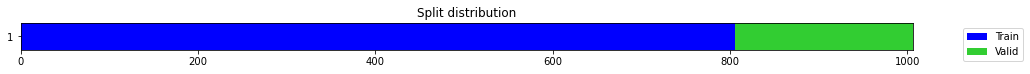

In [20]:
splits = get_splits(y, valid_size=.2, stratify=True, random_state=23, shuffle=False)
tfms  = [None, [TSRegression()]]
batch_tfms = TSStandardize(by_sample=True, by_var=True)
dls = get_ts_dls(X, y, tfms=tfms, splits=splits,batch_tfms=batch_tfms, bs=24)
dls

In [21]:
dls.one_batch()

(TSTensor(samples:24, vars:8, len:60, device=cuda:0),
 tensor([-1.6647e-03,  2.5787e-03,  5.5256e-04,  3.9835e-04, -1.7149e-03,
          2.0913e-03, -2.4303e-03,  1.2530e-03,  1.3890e-04, -9.5981e-04,
         -2.4101e-04,  1.9355e-03, -1.5801e-04, -9.2346e-03, -1.7093e-03,
         -8.6751e-04,  2.4345e-04, -1.4554e-04,  4.9716e-04,  7.9587e-03,
          2.1431e-03, -3.2447e-04, -2.5138e-05, -1.7463e-03], device='cuda:0'))

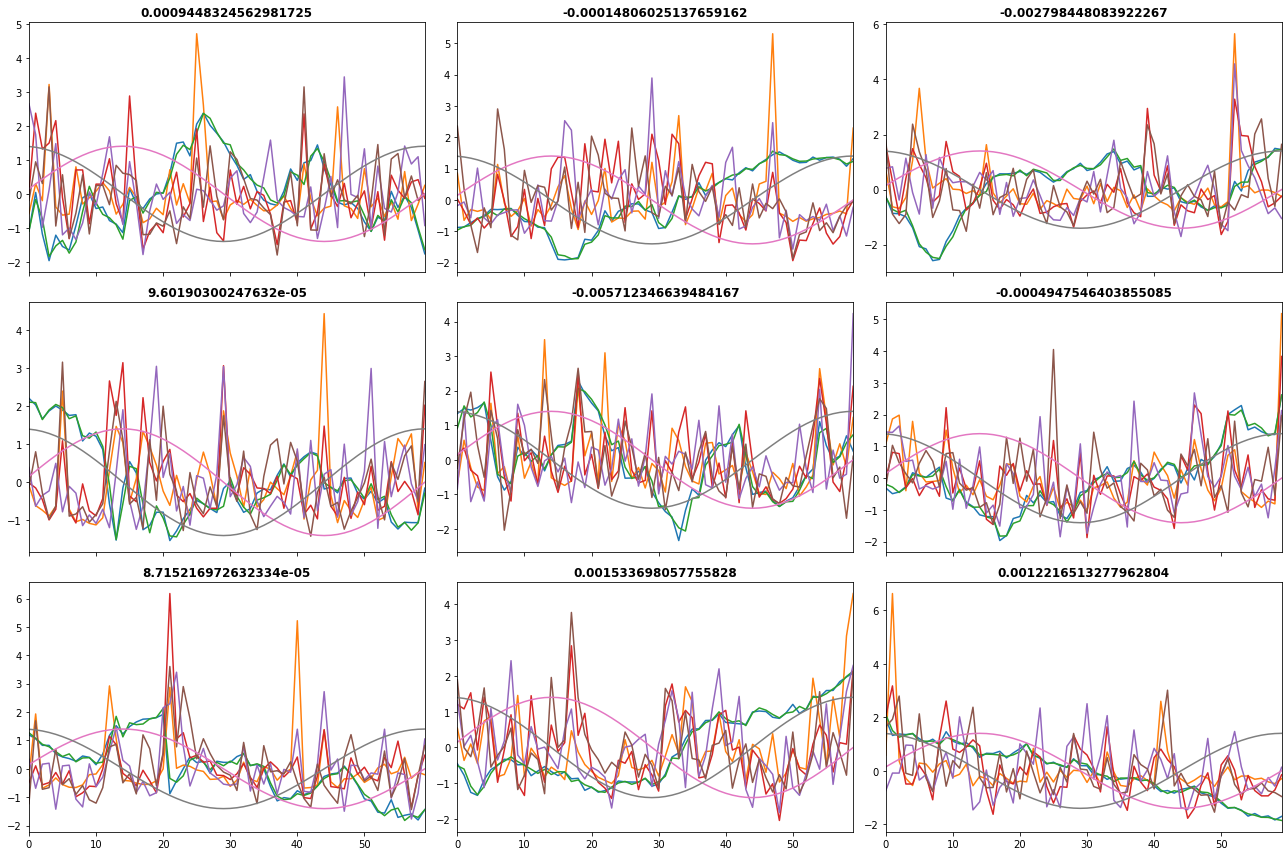

In [22]:
dls.show_batch()

SuggestedLRs(valley=5.248074739938602e-05)

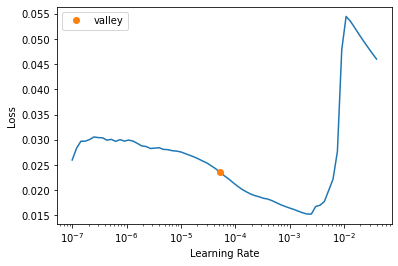

In [23]:
learn = ts_learner(dls, InceptionTime, metrics=[mae, rmse], cbs=ShowGraph())
learn.lr_find()

In [24]:
learn.loss_func

FlattenedLoss of MSELoss()

epoch,train_loss,valid_loss,mae,_rmse,time
0,0.008192,0.011967,0.102831,0.109394,00:00
1,0.004378,0.002235,0.038066,0.047277,00:00
2,0.002408,0.002374,0.039443,0.048724,00:00
3,0.001405,0.002229,0.038802,0.047215,00:00
4,0.001261,0.002171,0.036654,0.046599,00:00
5,0.002031,0.006845,0.070454,0.082733,00:00
6,0.001961,0.004136,0.054877,0.064310,00:00
7,0.001543,0.005507,0.065170,0.074210,00:00
8,0.001140,0.001164,0.028848,0.034112,00:00
9,0.000711,0.000422,0.016291,0.020539,00:00


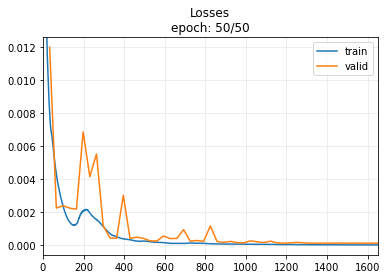

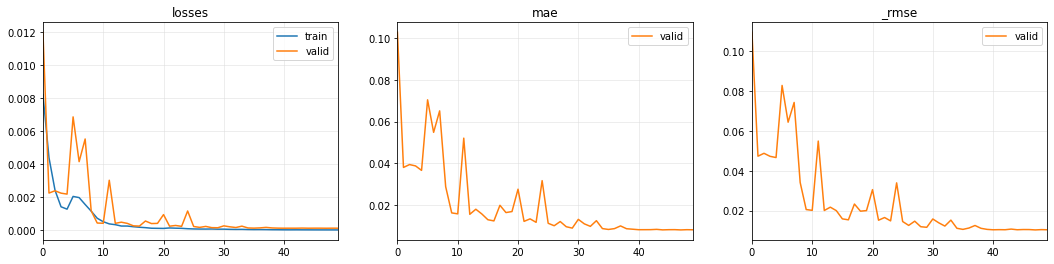

In [25]:
learn.fit_one_cycle(50,0.0004786300996784121)

Inference and predictions : the model seems to be pretty accurate

In [26]:
probas, _, preds = learn.get_X_preds(X[splits[1]])
skm.mean_squared_error(y[splits[1]], preds, squared=False)

0.010408141268149021